In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp  
    
# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown1e-6.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp.py'] ['Top Down 1e-1', 'Bottom Up (only last)', 'Top Down (only last)', 'Bottom Up 1e-6', 'Bottom Up 1e-2', 'Bottom Up 1e-10', 'Top Down 1e-0', 'Bottom Up 1e-0', 'Top Down 1e-4', 'Top Down 1e-6', 'Without simplify', 'Bottom Up 1e-4', 'Top Down', 'Top Down 1e-10', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up']
(539, 14)
['Without simplify' 'Top Down' 'Bottom U

model
Bottom Up    -12.97 \pm 65.48
Top Down     -11.44 \pm 50.20
dtype: object

Bottom Up greater TtestResult(statistic=-2.657521705226536, pvalue=0.9957080113400285, df=179)
Bottom Up less TtestResult(statistic=-2.657521705226536, pvalue=0.004291988659971506, df=179)
Top Down greater TtestResult(statistic=-3.049392631971995, pvalue=0.9986784060744363, df=178)
Top Down less TtestResult(statistic=-3.049392631971995, pvalue=0.0013215939255637687, df=178)


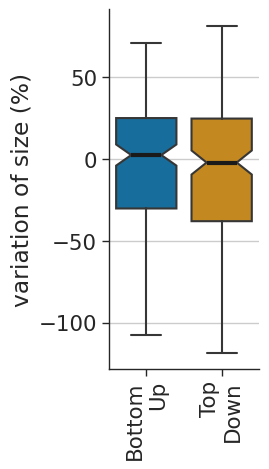

model
Bottom Up    -546.68 \pm 1415.40
Top Down     -682.70 \pm 1898.39
dtype: object

Bottom Up greater TtestResult(statistic=-5.181969819945301, pvalue=0.9999997059479583, df=179)
Bottom Up less TtestResult(statistic=-5.181969819945301, pvalue=2.9405204178013477e-07, df=179)
Top Down greater TtestResult(statistic=-4.81138445269361, pvalue=0.9999984082453418, df=178)
Top Down less TtestResult(statistic=-4.81138445269361, pvalue=1.591754658258373e-06, df=178)


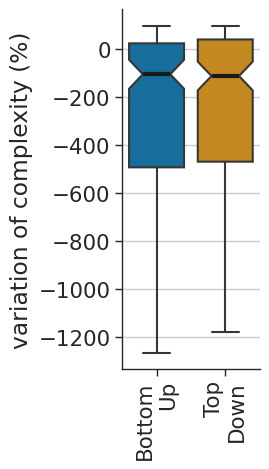

model
Bottom Up      9.35 \pm 82.05
Top Down     27.96 \pm 166.93
dtype: object

Bottom Up greater TtestResult(statistic=1.5283625623470385, pvalue=0.06409385659765116, df=179)
Bottom Up less TtestResult(statistic=1.5283625623470385, pvalue=0.9359061434023488, df=179)
Top Down greater TtestResult(statistic=2.2350338910928276, pvalue=0.013332896115558096, df=177)
Top Down less TtestResult(statistic=2.2350338910928276, pvalue=0.9866671038844419, df=177)


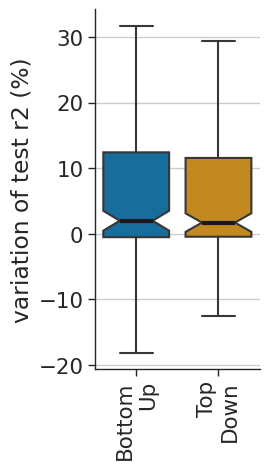

model
Bottom Up    -69.16 \pm 187.10
Top Down     -73.61 \pm 270.53
dtype: object

Bottom Up greater TtestResult(statistic=-4.9596082152635494, pvalue=0.9999991834295653, df=179)
Bottom Up less TtestResult(statistic=-4.9596082152635494, pvalue=8.165704346990937e-07, df=179)
Top Down greater TtestResult(statistic=-3.630251013435128, pvalue=0.9998147641402907, df=177)
Top Down less TtestResult(statistic=-3.630251013435128, pvalue=0.00018523585970929324, df=177)


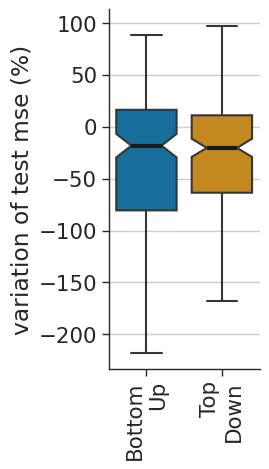

In [2]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplify'].groupby(['dataset', 'random_state']))

for metric in ['size', 'complexity', 'test_r2', 'test_mse']:
    speeds    = []
    for (model, dataset, random_state), group_df in \
        results_df.loc[results_df['model'] != 'Without simplify'].groupby(['model', 'dataset', 'random_state']):
        # 'contextual' is used as a hue in the plots

        baseline_curve = baseline_convergence.get_group((dataset, random_state))
        
        metric_baseline = baseline_curve[metric].values[0]
        metric_model = group_df[metric].values[0]
        speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

    speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])

    display(speeds_df.groupby(['model'])
            .agg(['mean','std'])
            .applymap(lambda x: '{0:.2f}'.format(x))
            .agg(r' \pm '.join, axis=1)
            )

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
    for model in speeds_df['model'].unique():
        print(model, 'greater',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='greater'
              )
        )
        print(model, 'less',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='less'
              )
        )

    g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
        #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
        legend_out=False, aspect=0.6,
        order = [o for o in order if o != 'Without simplify'], # The first is Baseline
        **boxplot_kwargs, sharey=False
    )

    # g.set(yscale="log")

    g.set_titles("{col_name}").set_axis_labels("", f"variation of {metric.replace('_', ' ')} (%)")

    # iterate through each subplot / Facet
    single_plot = True
    for (ds, plot_ax) in g._axes_dict.items():
        single_plot = False
        plot_ax.grid(which='major', axis='y', linewidth=1)
        #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('_', ' '))

        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        plot_ax.set_xticklabels([tl.replace(' ', '\n')for tl in plot_ax.get_xticklabels()], 
                            rotation=90, 
                            horizontalalignment='right')

        # Contextual vs non-contextual
        pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

        if False:
            annotator = Annotator(
                plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
                x='model', y='Speed up',
                order=order[1:])
            annotator.reset_configuration()
            annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
            
            # Calculate and annotate
            annotator.apply_and_annotate()
            
    if single_plot: 
        g.ax.grid(which='major', axis='y', linewidth=1)
        #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in g.ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        g.ax.set_xticklabels([tl.get_text().replace(' ', '\n')for tl in g.ax.get_xticklabels()], 
                            rotation=90, 
                            ha='center',  va='top', ma='right')

    plt.tight_layout()
    plt.savefig(f"../paper/figs/delta_{metric}.pdf")
    plt.savefig(f"../paper/figs/delta_{metric}.png")
    plt.show()

In [3]:
print(sns.color_palette("colorblind").as_hex())
sns.color_palette("colorblind").as_hex()

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']